In [9]:
import numpy as np
# import pylab as pl
import random
import matplotlib
import matplotlib.pyplot as plt
from scipy.integrate import odeint



# Problem 1: Gillespies algorithm

In [10]:
Rate=np.zeros((6))
Change=np.zeros((6,3))
N=np.sum(V[range(3)])
Rate[0] = beta*V[0]*V[1]/N; Change[0,:]=([-1, +1, 0]);
Rate[1] = gamma*V[1];  Change[1,:]=([0, -1, +1]);
Rate[2] = mu*N;  Change[2,:]=([+1, 0, 0]);
Rate[3] = mu*V[0];  Change[3,:]=([-1, 0, 0]);
Rate[4] = mu*V[1];  Change[4,:]=([0, -1, 0]);
Rate[5] = mu*V[2];  Change[5,:]=([0, 0, -1]);


N = sum(initial)
initial = np.array(initial)
rates[0] = mu*N  #Birth
#Handling division by zero issues
if initial[0] > 0 and initial[1] > 0:
    rates[1] = beta*initial[0]*initial[1]/N
else:
    rates[1] = 0
rates[2] = gamma*initial[1] #
rates[3] = mu*initial[0]
rates[4] = mu*initial[1]
rates[5] = mu*initial[2]
changes = np.array([[1,0,0],[-1, 1, 0], [0,-1, 1], [-1, 0, 0], [0, -1, 0], [0, 0 ,-1]])

NameError: name 'V' is not defined

In [ ]:
print(np.zeros((6,3)))
print(np.array([[1,0,0],[-1, 1, 0], [0,-1, 1], [-1, 0, 0], [0, -1, 0], [0, 0 ,-1]]))

In [ ]:
def sir_event(initial,time, params): 
    """We asumme inital conditions as integers and X,Y,Z ordered"""
    gamma, beta, mu = params[0], params[1], params[2]
    rates = np.zeros(6)
    N = sum(initial)
    initial = np.array(initial)
    rates[0] = mu*N  #Birth
    #Handling division by zero issues
    if initial[0] > 0 and initial[1] > 0:
        rates[1] = beta*initial[0]*initial[1]/N
    else:
        rates[1] = 0
    rates[2] = gamma*initial[1] #
    rates[3] = mu*initial[0]
    rates[4] = mu*initial[1]
    rates[5] = mu*initial[2]
    changes = np.array([[1,0,0],[-1, 1, 0], [0,-1, 1], [-1, 0, 0], [0, -1, 0], [0, 0 ,-1]])
    dtm = []
    for rate in rates:
        if rate == 0:
            dtm.append(1000)
        else:
            dtm.append(-np.log(np.random.rand())/rate)
    indx = np.argmin(dtm)
    dt = dtm[indx]
    event = np.array([initial + changes[indx]]).T
    return event, time + dt


def event_loop(tmax, initial, function, arguments):
    '''Keeps loop for '''
    time = [0]
    results = np.array([[value] for value in initial])
    k = 0
    while time[-1] < tmax:
        event, tn = function(initial, time[-1], arguments)
        results = np.concatenate((results, event), axis= 1)
        initial = event[:,0]
        time.append(tn)
        k += 10
        if k == 10:
#             print(time[-1])
            k = 0
    time = np.array(time)
    return time, results

In [ ]:
p =  [0.15, 2, 1/(365*60)]
N = 10000 #Dont go above 1e4

populations = np.round(N* np.array([0.85, 0.15, 0]))
x, y = event_loop(30, populations, sir_event,p )

# print(y[0;])
plt.plot(x, y[0,:], label = 'Susceptible')
plt.plot(x, y[1,:], label = 'Infected')
plt.plot(x, y[2,:], label = 'Recovered')

plt.xlabel('Days')
plt.ylabel('Individuals')
plt.legend()
plt.xlim(0, 30)

In [ ]:
t= np.diff(x)
# print(t)
t = t[t < 0.5]
plt.hist(t)

## Investigating simulation variability

## Simulation variability and negative covariance

In [ ]:
# We first define the deterministic SIR model

def SIR(initial, t, gamma, beta, mu):   
    Y = np.zeros(3) 
    Y[0] = mu - beta * initial[0] * initial[1] - mu * initial[0]
    Y[1] = beta * initial[0] * initial[1] - gamma * initial[1] - mu * initial[1]
    Y[2] = gamma * initial[1] - mu * initial[2]
    return Y   


First we run both deterministic and stochastic models for different R0's many times

In [1]:
# This code runs stochastic model for given R0's and stores then in a dictionary
#Key to dictionary is reproductive numbers
#Setting model parameters
betas = np.linspace(0.2,3, 5)
gamma = 0.15
mu = 1/(60*365)
reproductive = betas/(mu+gamma)
print(betas)
print(reproductive)
# Seeting population size 
N = 100
populations = np.round(100* np.array([0.85, 0.15, 0]))
tmax = 20

# Setting time array for deterministic model
time = np.arange(0,tmax+1,1)


# First run stochastic model for different R0s for 10 times 
stoch_runs = {}
det_run = {}

# Outer loop which varies the beta we apply to both models
for indx, r0 in enumerate(reproductive) :
    print(f"Current R0: {r0}")
    temp = []
    beta = betas[indx]
    # Running stochastic model many times with same beta
    for k in range(10):
#         print(f"k = {k}")
        params = [gamma, beta, mu]
        tn, y = event_loop(tmax, populations, sir_event,params)
        temp.append([tn, y])
    #Saving stochastic results
    stoch_runs[r0] = temp
    print('Running deterministic model now')
    #Running and saving deterministic output
    det_output = odeint(SIR, populations, time, args = (gamma, beta, mu))
    det_run[r0] = [time, det_output]

# print(stoch_runs[1.3329275715155204])

NameError: name 'np' is not defined

### Calculating variance and covariance

In [46]:
# This function calculates average variances and covariances for each R0 run we have
# 1. Calculate average variance per reproductive number
def var_calc (stoch_runs):
    variances = {}
    covariances= {}
    for r0 in stoch_runs:
#         print(f"Reproductive number:{r0}")
        #We get runs for every R0
        runs = stoch_runs[r0]
        varS = []
        varI = []
        varR = []
        varComb = []
        covSI = [] #The covariance between susceptible and infected
        for run in runs:
            results = run[1]
            varS.append(np.var(results[0,:]) )
            varI.append(np.var(results[1,:]))
            varR.append(np.var(results[2,:]))
            varComb.append(np.average([varS[-1], varI[-1], varR[-1]]))
            #Covariances
            covSI.append(np.cov(results[0,:], results[1,:], rowvar=False)[0, 1])
        #Adding variances 
        variances[r0] = (np.average(varS), np.average(varI), np.average(varR), np.average(varComb))
        covariances[r0] = np.average(covSI)
    return variances, covariances
variances, covariances = var_calc (stoch_runs)

In [48]:
# This part just extracts all the variances and covariances to a normal list for easy plotting
r0s = reproductive

def whatever(variances, covariances, reproductive):
    varS = []
    varI = []
    varR = []
    covarSI = []
    varComb = []
    for r in reproductive:
        varS.append(variances[r][0])
        varI.append(variances[r][1])
        varR.append(variances[r][2])
        varComb.append(variances[r][3])
        covarSI.append(covariances[r])
    return varS, varI, varR, varComb, covarSI
    
varS, varI, varR, varComb, covarSI = whatever(variances, covariances, reproductive)    
var = [varS, varI, varR, varComb]

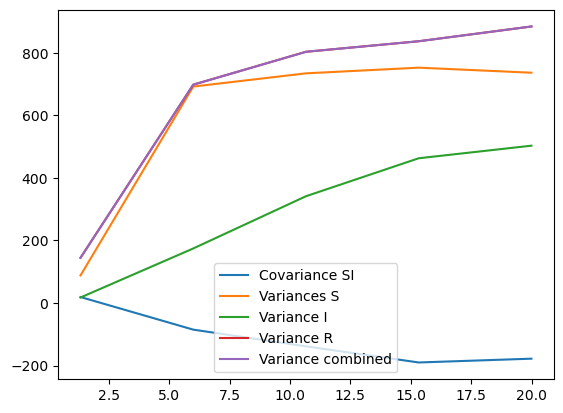

In [50]:
plt.plot(reproductive, covarSI, label = 'Covariance SI')
plt.plot(reproductive, var[0], label = 'Variances S')
plt.plot(reproductive, var[1], label = 'Variance I' )
plt.plot(reproductive, var[2], label = 'Variance R')
plt.plot(reproductive, var[2], label = 'Variance combined')

plt.ylabel('Variance')
plt.legend()

### Comparing means between stochastic and deterministic model

In [68]:
sampling_times = np.arange(0,20+1,1)

# Defining variables where 
# This code 'samples' values closest to the sampling times we define (as stochastic model has different timesteps)
def sampler(times,stoch_runs):
    final_dic = {}
    for key in stoch_runs:
        print(f"Current R0: {key}")
        #We set data for each R0 we have used
        runs = stoch_runs[key]
        Sn = [[] for x in times]
        In = [[] for x in times]
        Rn = [[] for x in times]
        for indx, t in enumerate(times):
            for run in runs:
                tn, data = run[0], run[1]
                time_differences = np.abs(tn-t)
                location_indx = np.argmin(time_differences)
                sample = data[:,location_indx]
                Sn[indx].append(sample[0])
                In[indx].append(sample[1])
                Rn[indx].append(sample[2])
#         print(len(Sn))
        S = [np.average(tn) for tn in Sn]
        I = [np.average(tn) for tn in In]
        R = [np.average(tn) for tn in Rn]
        #Adding data to dictionary for each R0
        final_dic[key] = np.array([S,I,R])
    return final_dic

stoch_samples = sampler(sampling_times, stoch_runs)

Current R0: 1.3329275715155204
Current R0: 5.998174071819841
Current R0: 10.663420572124163
Current R0: 15.328667072428484
Current R0: 19.993913572732808


In [79]:
# Reproductive
r0 = reproductive[1]
stochS, stochI, stochR = stoch_samples[r0]
detS, detI, detR = det_run[r0][1][1,:], det_run[r0][1][:,2], det_run[r0][1][:,2]
print(detS)
# print(len(G))

# plt.plot()

# print(stoch_samples[reproductive[1]])

[5.86288471e-07 8.63402135e+01 1.36552655e+01]


(20,)


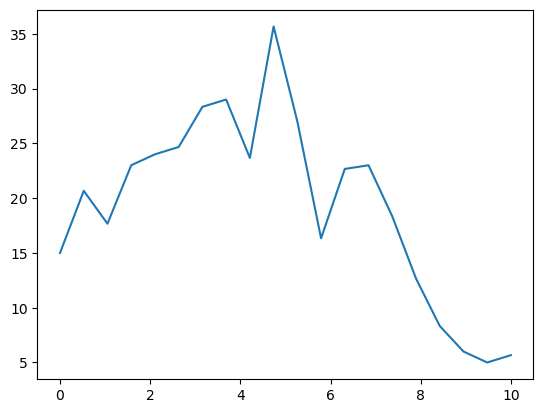

In [178]:
data = stoch_samples[1.2633689839572193]
print(data[1].shape)
plt.plot(sampling_times,data[1,:])

## Stochastic resonance and Increased transients

Defining function for phase plots

In [5]:
def event_phase_plot(Ns,initials, parameters, tmax):
    for initial in initials:
        print(f"Current initial: {initial}")
        x, y = event_loop(tmax, initial, sir_event,parameters)
        S, I = y[0,:], y[1,:]
        plt.plot(S,I, 'c')
        plt.ylabel('Infected')
        plt.xlabel('Susceptible')
    plt.scatter(initials[:,0], initials[:,1])

In [8]:
N = 1000
dx = N/5

S = np.concatenate((np.arange(0,N+dx, dx), np.arange(0,N+dx, dx)))
I = np.concatenate((np.arange(0,N+dx, dx)[::-1], np.array([5 for k in range(6)])))
print(S.shape)
print(I.shape)
R= np.zeros(12)
print(R.shape)
initial = np.array([S, I, R]).T
p =  [1/10, 1, 0.05]
tmax = 30
print(initial)

# x, y = event_loop(tmax, populations, sir_event,p )
# plt.plot(x, y[0,:], label = 'Susceptible')


# plt.plot(x, y[])
event_phase_plot(N, initial,p, 80 )

NameError: name 'np' is not defined

In [7]:
initial = [[500,500,0]]
event_phase_plot(initial, initial,p, 80 )
plt.title('$N$')
# STREAMPLOT

NameError: name 'p' is not defined

## Extinction events and critial community size

In [ ]:
# Define loop where we stop  when infection reaches extinction
def event_loop2(initial, function, arguments):
    '''Keeps loop for '''
    time = [0]
    results = np.array([[value] for value in initial])
    k = 0 
    while True:
        event, tn = function(initial, time[-1], arguments)
        results = np.concatenate((results, event), axis= 1)
        initial = event[:,0]
        time.append(tn)
        if event[1][0] == 0:
            break
    time = np.array(time)
    return time, results

### Effect of population size N

In [ ]:
# Run montecarlo simulation with one N and collect values --> Calculate median value per N value
beta = 1.5
gamma = 0.15
mu = 1/(60*365)
np.random.seed(69)

# Running loop for different Ns
Ns = np.logspace(1, 4, 6)
end_times = []

for j in range(len(Ns)):
    N = Ns[j]
    I0 = int(N * (0.25))
    S0 = int(N * 0.75)
    R0 = int(N * 0)
    initial = [S0, I0, R0]
    t = [] 
    print(f"Current N: {N}")
    for k in range(5):
#         print(f"Current k: {k}")
        initial = [S0, I0, R0]
        params = [gamma, beta, mu]
        times, results = event_loop2(initial, sir_event,params)
        t.append(times[-1])
    avg_time = np.average(t)
    end_times.append(avg_time)
    
plt.scatter(Ns, end_times)
plt.plot(Ns, end_times)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Population Size N')
plt.ylabel('Average extinction time')
# Run simulation for differnt N's , Run multiple times and compile all the final times

### Effect of R0

In [ ]:
# Setting random number seed
np.random.seed(69)

# Run montecarlo simulation with one N and collect values --> Calculate median value per N value
gamma = 0.15
mu = 1/(60*365)
betas = np.arange(gamma,3,0.3)

N = 100
I0 = int(N * (0.25))
S0 = int(N * 0.75)
R0 = int(N * 0)

Rp = betas/(gamma + mu)
end_times = []
for j in range(len(Rp)):
    beta = betas[j]
    print(Rp[j])
    params = [gamma, beta, mu]
    t = [] 
    for k in range(10):
        times, results = event_loop2(initial, sir_event,params)
        t.append(times[-1])
    avg_time = np.average(t)
    end_times.append(avg_time)
    
plt.scatter(Rp, end_times)
plt.plot(Rp, end_times)
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'$R_0$')
plt.ylabel('Average extinction time')

In [ ]:
plt.scatter(Rp, end_times)
plt.plot(Rp, end_times)
# plt.yscale('log')
# plt.xscale('log')
plt.xlabel(r'$R_0$')
plt.ylabel('Average extinction time')

# Problem 2: Spatial models - Networks

In [11]:
import networkx as nx
import ndlib.models.epidemics as ep
from ndlib.viz.mpl.DiffusionTrend import DiffusionTrend
import ndlib.models.ModelConfig as mc
from ndlib.viz.mpl.DiffusionPrevalence import DiffusionPrevalence
from ndlib.utils import multi_runs
# from ndlib.viz.bokeh.MultiPlot import MultiPlot


no display found. Using non-interactive Agg backend


In [12]:
%matplotlib inline

## Implementing SIR on different networks: Barabasi Albert, Watts-Strogatz, Erdos-Reyni

## Generating equivalent networks

In [13]:
Ns = np.logspace(0, 3, 3)
print(Ns)

[   1.          31.6227766 1000.       ]


In [14]:

def scale_free(Ns, m=20, seed=1):
    '''Barabasi networks'''
    lst = []
    for n in Ns:
        g = nx.barabasi_albert_graph(int(n), m, seed)
        lst.append(g)
    return lst

def smallworld(Ns, m=20,p = 0.1, seed=1):
    ''' Watts–Strogatz networks'''
    lst = []
    for n in Ns:
        g = nx.watts_strogatz_graph(int(n), m, p,seed)
        lst.append(g)
    return lst


def binomial(Ns, p =0.1, seed=1):
    ''' Erdős–Rényi'''
    lst = []
    for n in Ns:
        g = nx.erdos_renyi_graph(int(n), p)
        lst.append(g)
    return lst

Ns = [100,1000]

scale_g = scale_free(Ns)
small_g = smallworld(Ns)
binom_g = binomial(Ns)


Visualizing graphs where N = 1000

In [60]:
g1, g2, g3 = scale_g[0], small_g[0], binom_g[0]

pos1 = nx.nx_agraph.graphviz_layout(g1)
pos2 = nx.nx_agraph.graphviz_layout(g2)
pos3 = nx.nx_agraph.graphviz_layout(g3)

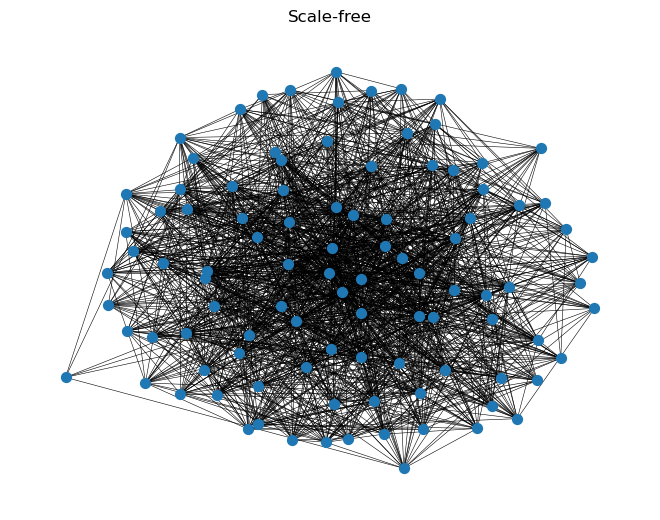

In [61]:
# pos1 = nx.spring_layout(g1, scale=10)
nx.draw(g1,pos1, node_size=50, width=0.4)

# Display the graph
plt.title('Scale-free')
plt.show()

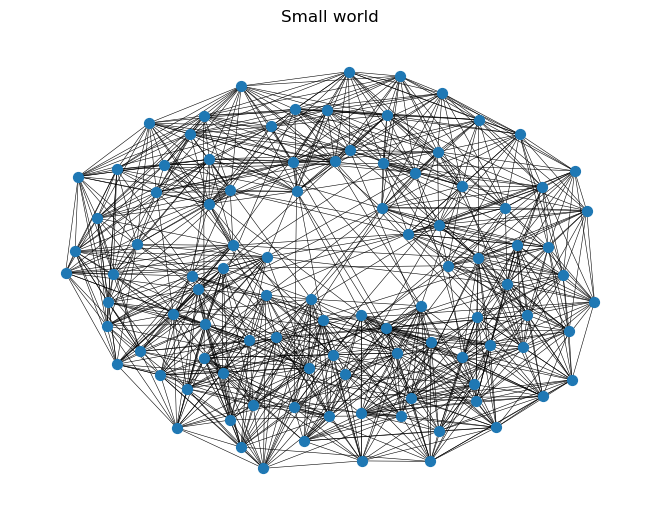

In [62]:
nx.draw(g2,pos2, node_size=50, width=0.4)

# Display the graph
plt.title('Small world')
plt.show()

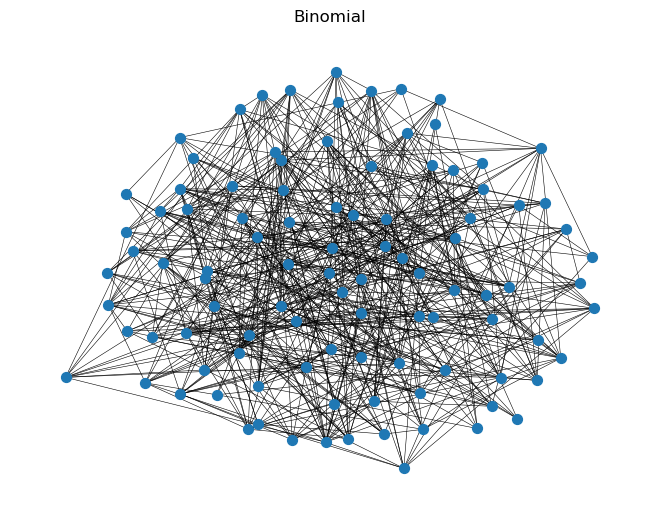

In [63]:
nx.draw(g3,pos1, node_size=50, width=0.4)

# Display the graph
plt.title('Binomial')
plt.show()

### Implementing SIR 

In [26]:
def simple_sir(graph, beta, gamma, perc_infected,infected_nodes=None,iterations = 200):
    model = ep.SIRModel(graph)  
    cfg = mc.Configuration()
    cfg.add_model_parameter('beta', beta) # infection rate
    cfg.add_model_parameter('gamma', gamma) # recovery rate
    
    if not infected_nodes:
#         print("using percentage")
        cfg.add_model_parameter("percentage_infected", perc_infected)
        model.set_initial_status(cfg)
    else:
#         print('using infected nodes')
        cfg.add_model_initial_configuration("Infected", infected_nodes)
        model.set_initial_status(cfg)
   
    iterations = model.iteration_bunch(iterations, node_status=True)
    return model, iterations

# Setting parameters
beta = 0.001
gamma =0.01
percentage_infected = 0.01
nruns = 300

beta, gamma, percentage_infected ,nruns
0.001 0.01 0.01 300


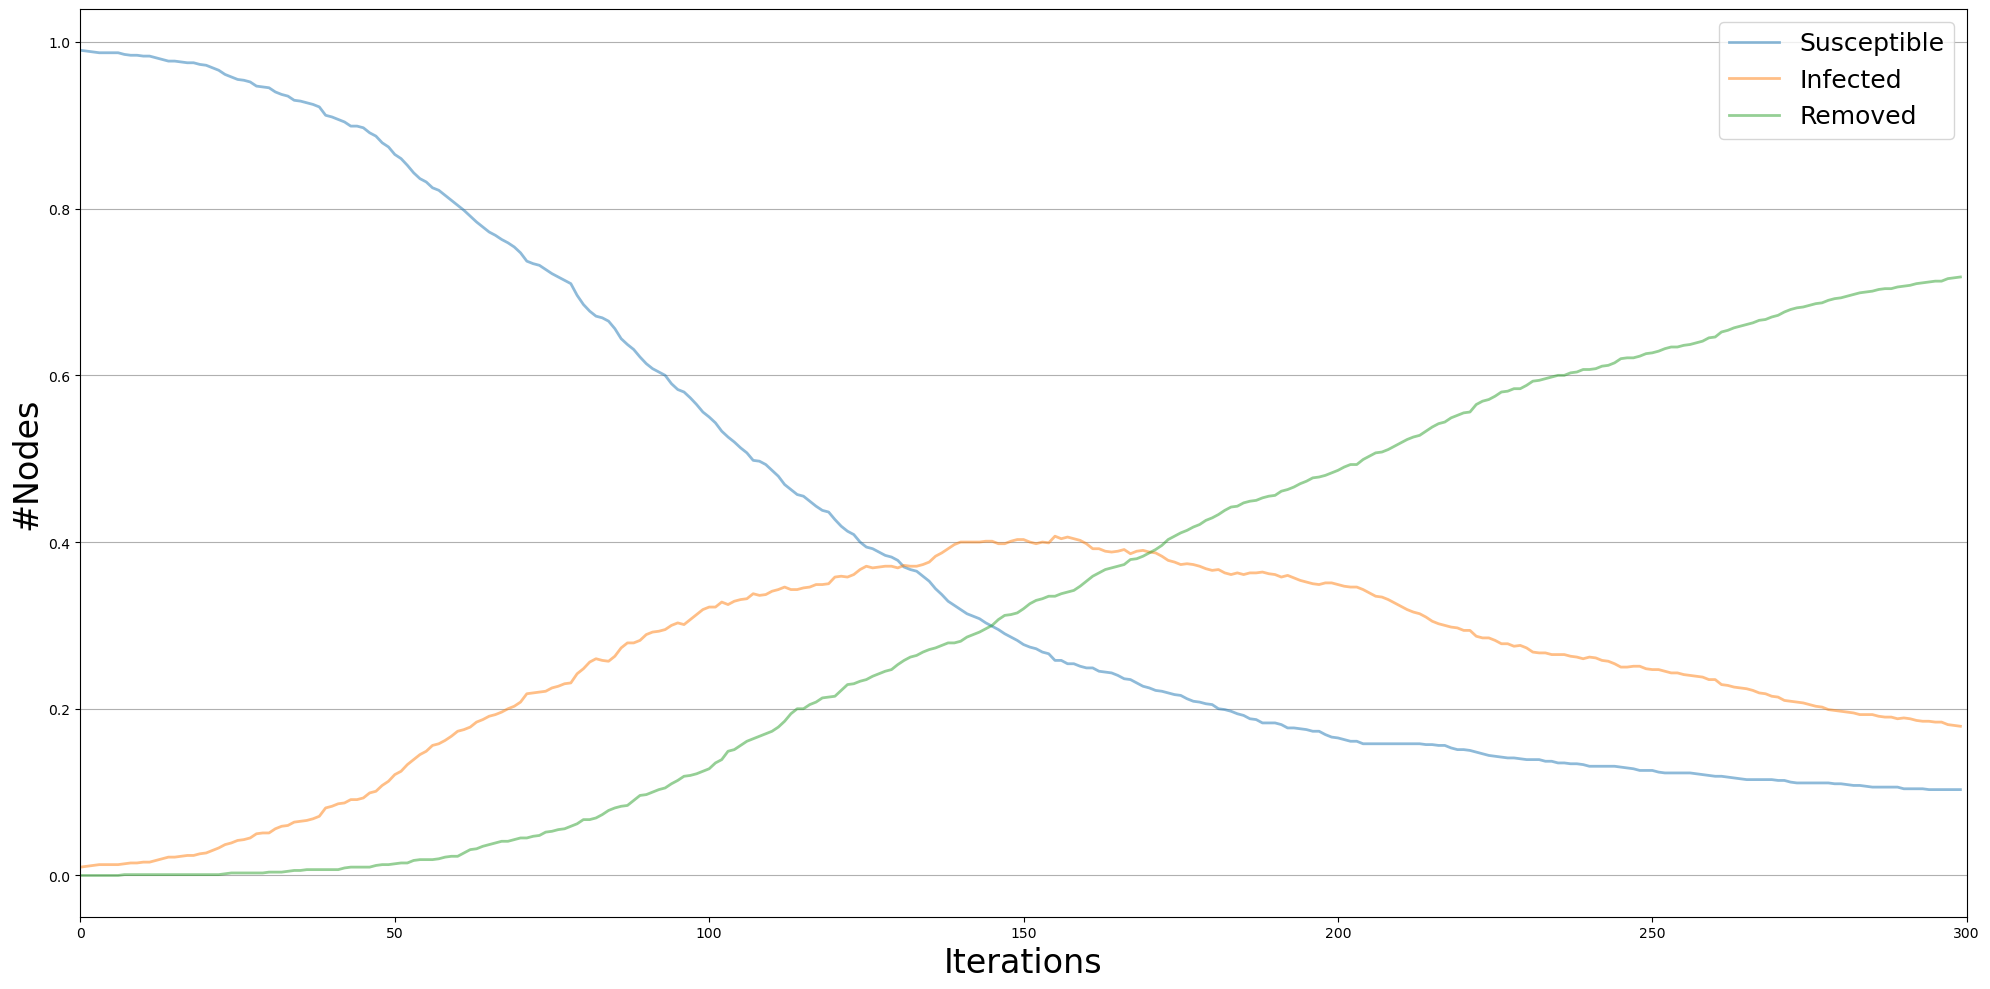

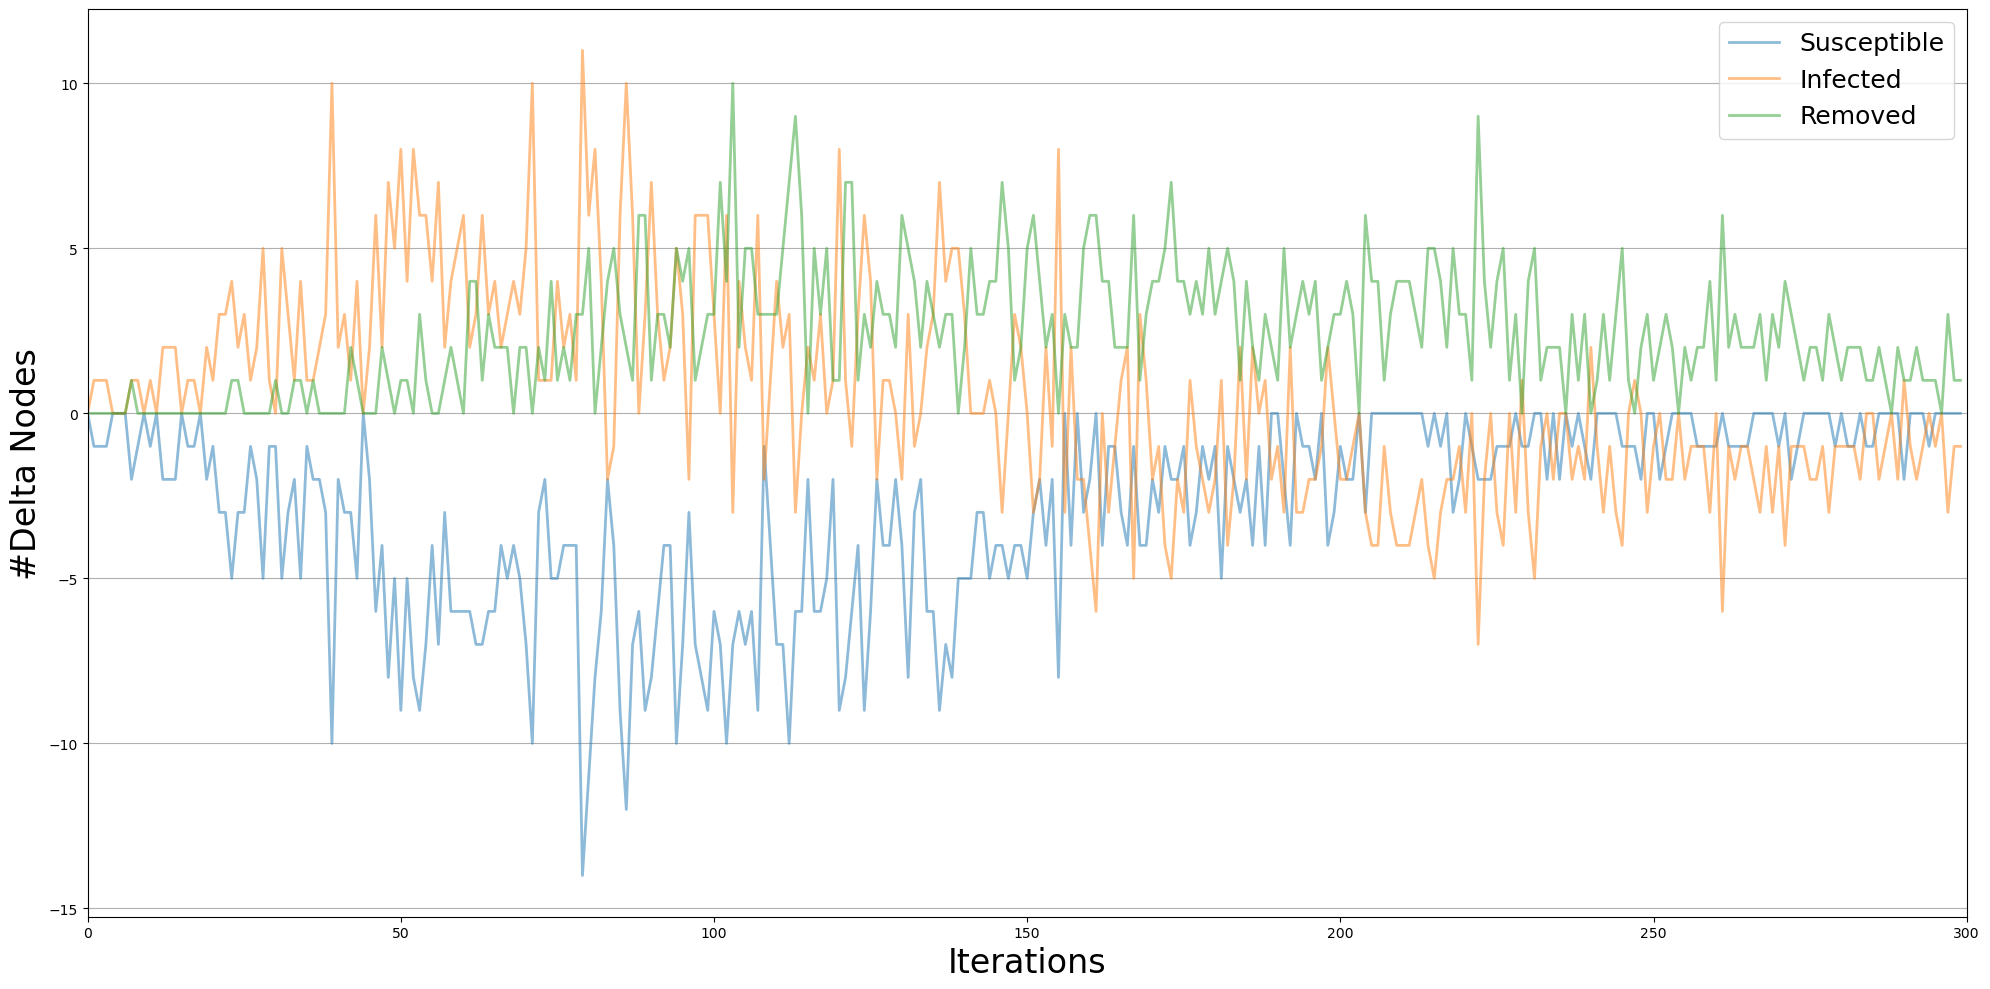

In [33]:
print("beta, gamma, percentage_infected ,nruns")
print(beta, gamma, percentage_infected ,nruns)
graph = scale_g[-1]
model, iterations = simple_sir(graph, beta, gamma, percentage_infected ,iterations = nruns)
# print(iterations[0]['status'])
trends_ex = model.build_trends(iterations)

viz = DiffusionTrend(model, trends_ex)
viz.plot()


viz = DiffusionPrevalence(model, trends_ex)
viz.plot()

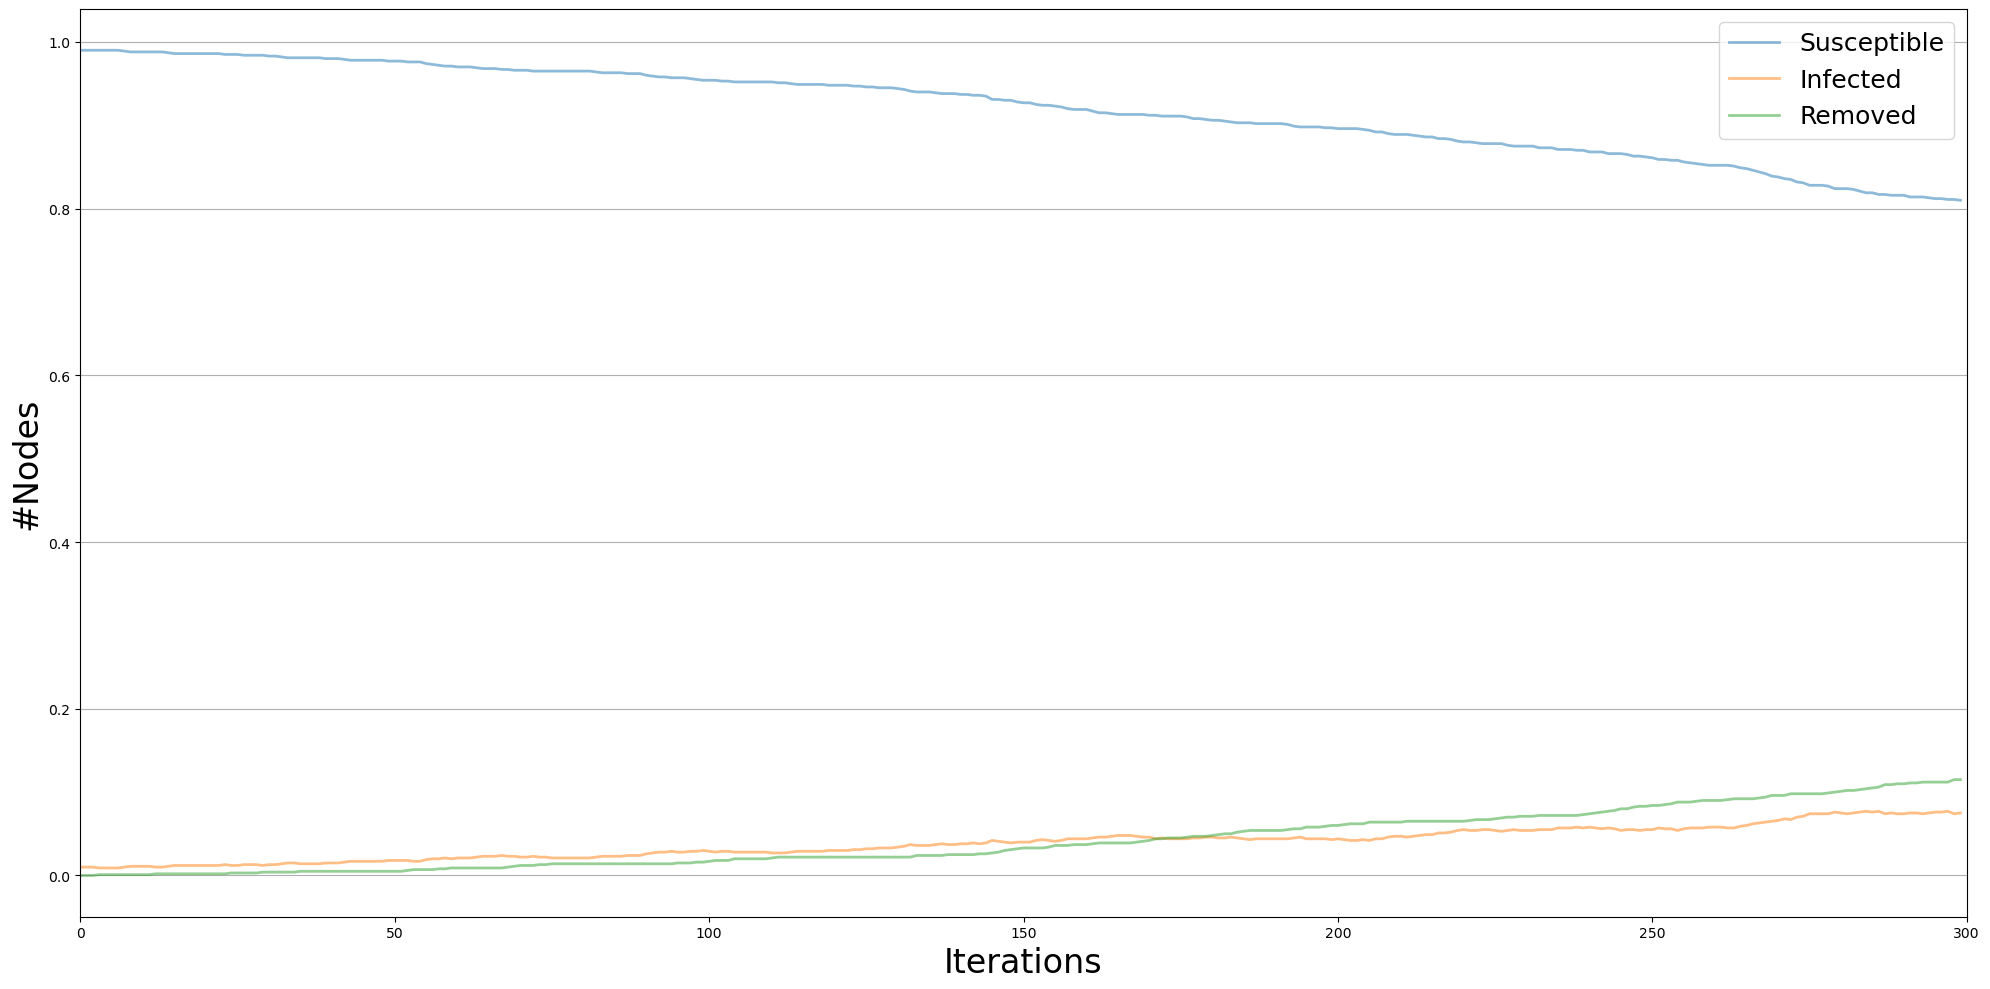

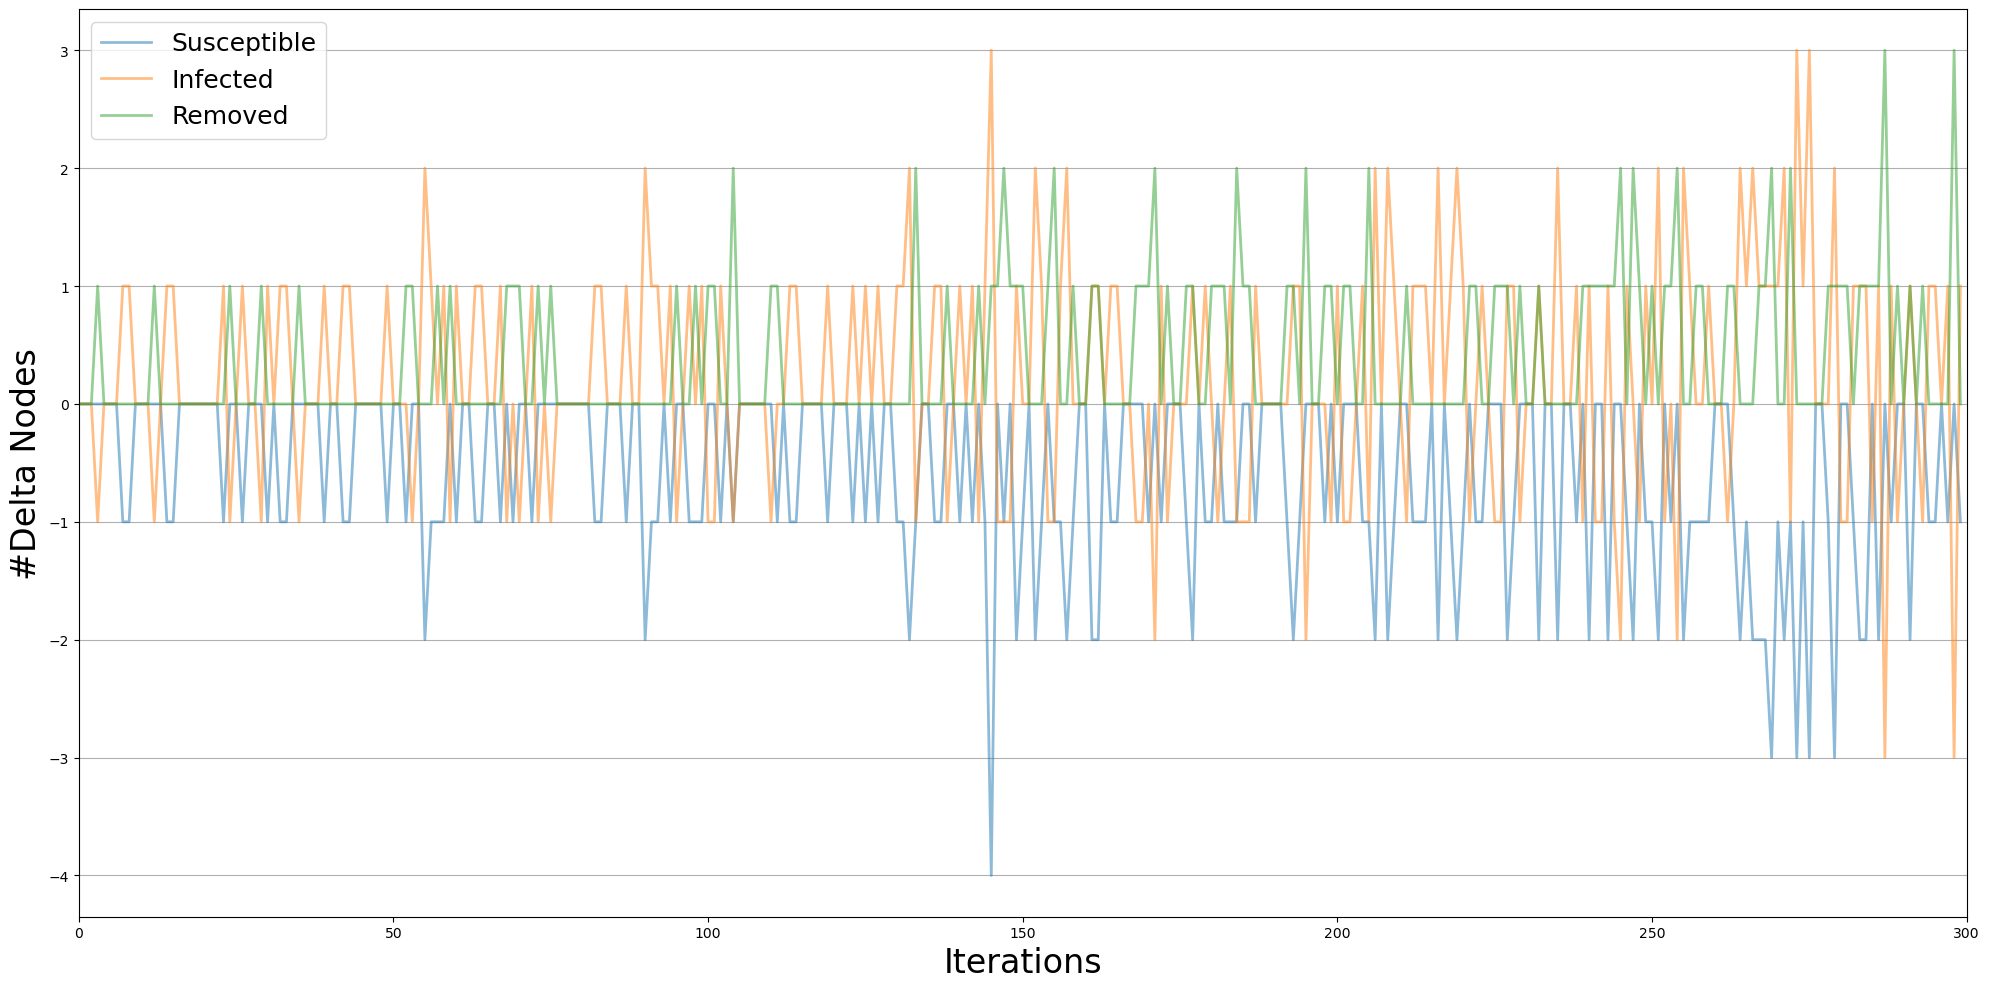

In [30]:
graph = small_g[-1]
model, iterations = simple_sir(graph, beta, gamma, percentage_infected ,iterations = nruns)
trends = model.build_trends(iterations)
viz = DiffusionTrend(model, trends)
viz.plot()

viz = DiffusionPrevalence(model, trends)
viz.plot()

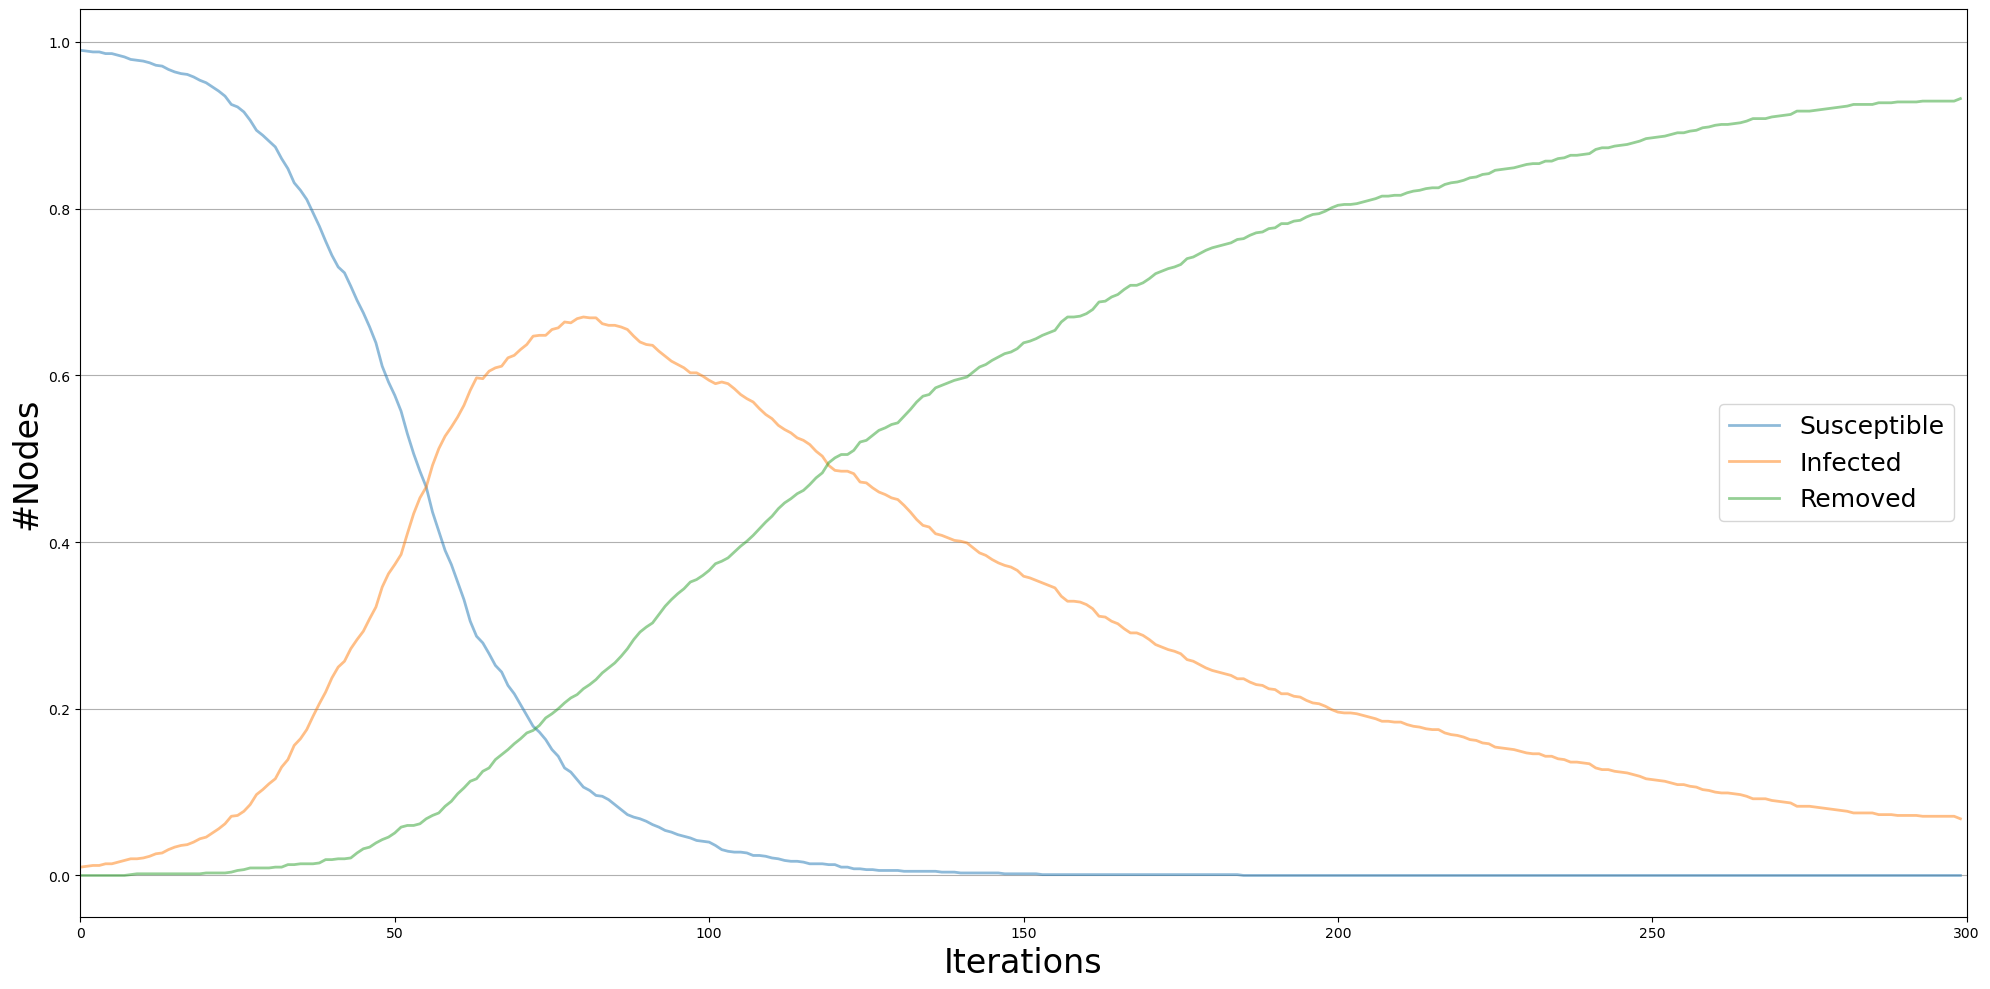

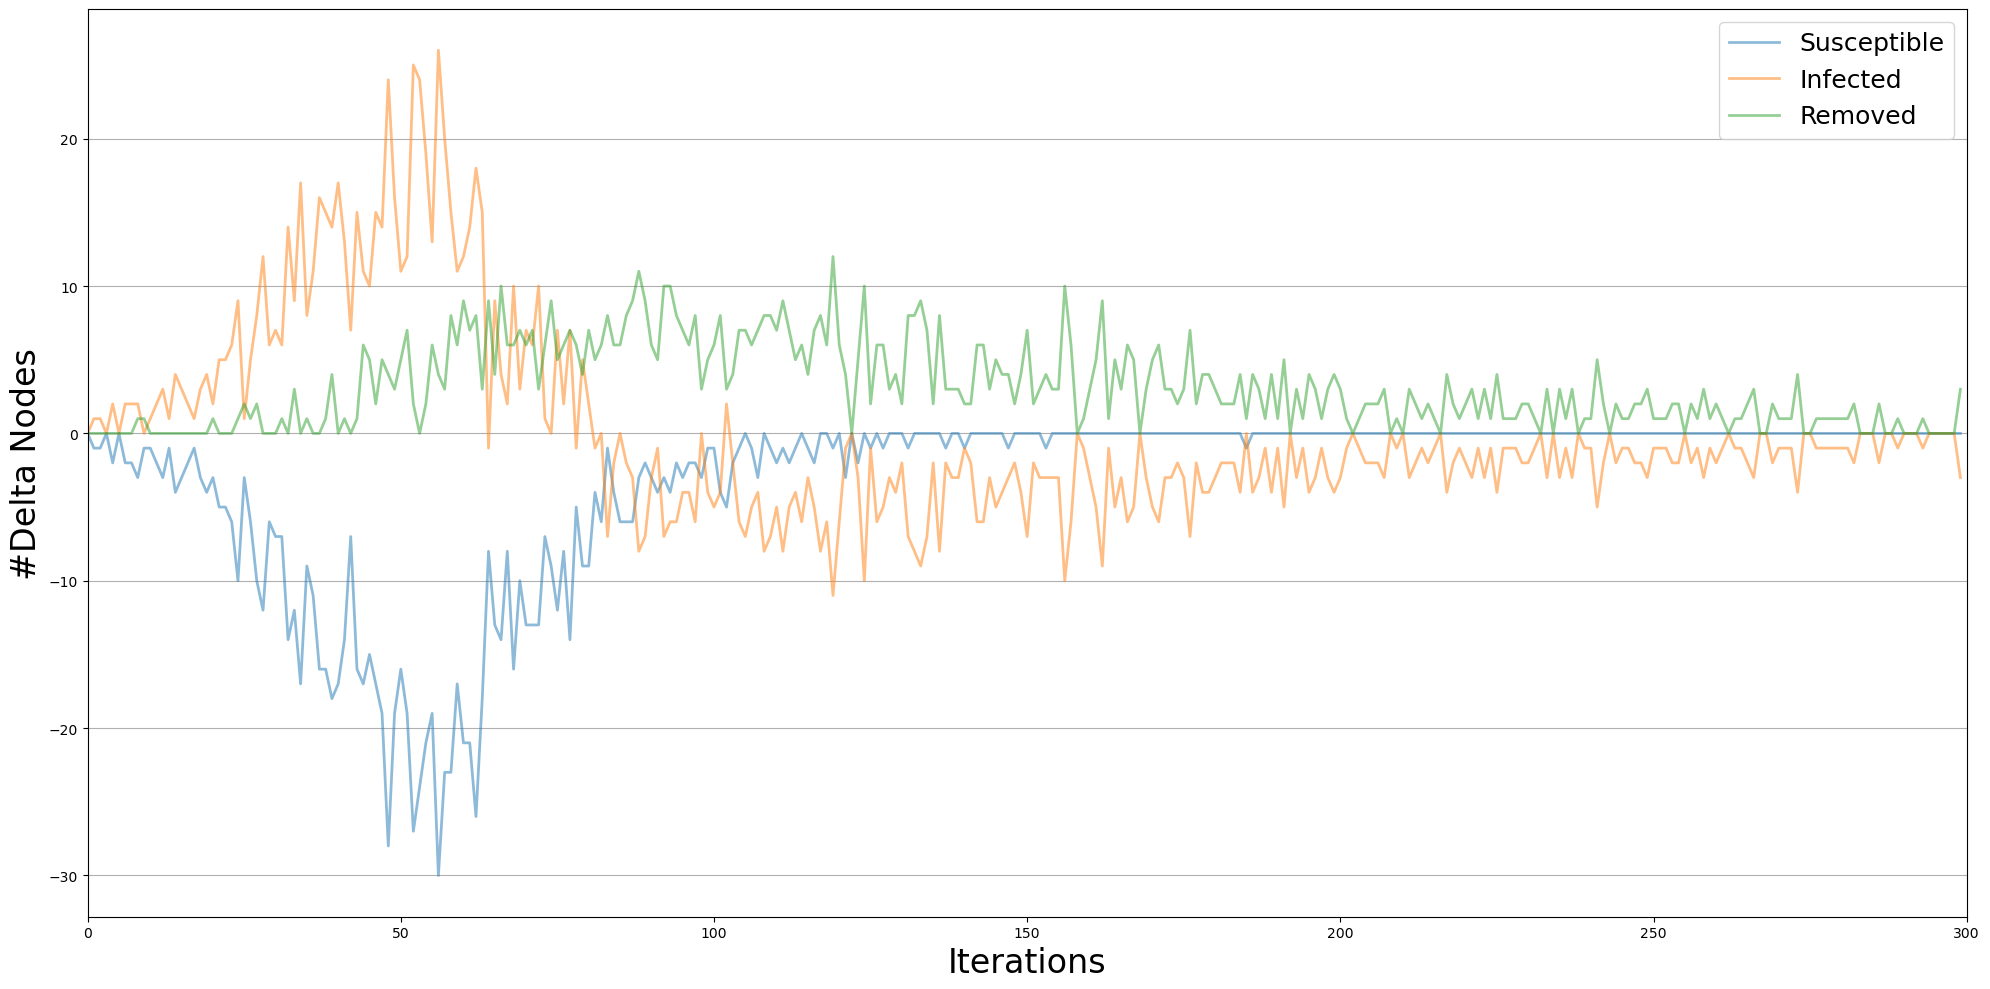

In [34]:
graph = binom_g[-1]
model, iterations = simple_sir(graph, beta, gamma, percentage_infected ,iterations = nruns)
trends = model.build_trends(iterations)
viz = DiffusionTrend(model, trends)
viz.plot()

viz = DiffusionPrevalence(model, trends)
viz.plot()

## Calculating network properties per network type and plotting

In [74]:
 
def g_properties(graphs):
    properties = {}
    clustering = np.array([nx.average_clustering(g) for g in graphs])
    path_length = np.array([nx.average_shortest_path_length(g) for g in graphs])
    return path_length, clustering

Ns = np.round(np.linspace(100,5000,5))

x1, x2, x3 = scale_free(Ns), smallworld(Ns), binomial(Ns)


scale_pl , scale_clust= g_properties(x1)
small_pl , small_clust= g_properties(x2)
binom_pl , binom_clust= g_properties(x3)



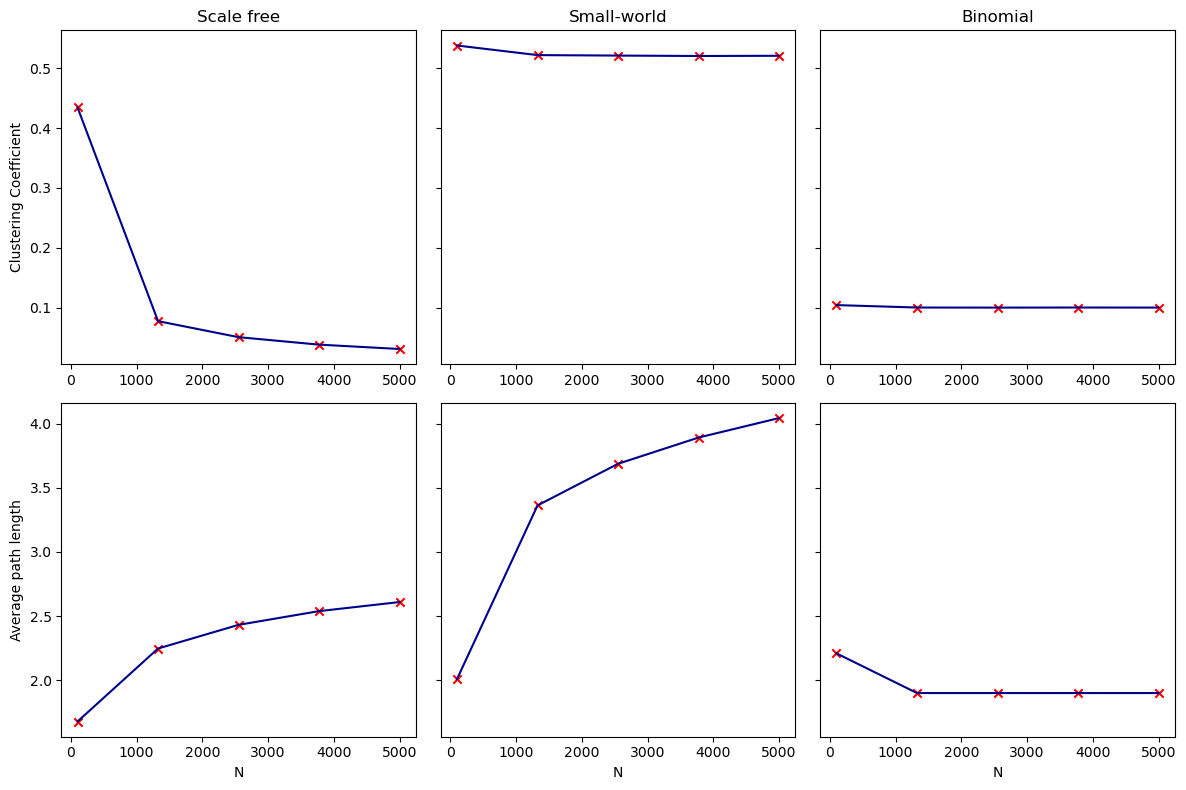

In [82]:
# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8), sharey='row')

# Plotting on the top row
axes[0, 0].scatter(Ns, scale_clust, color='red', marker='x')
axes[0, 0].plot(Ns, scale_clust, color='darkblue')
axes[0, 0].set_title('Scale free')
axes[0, 0].set_ylabel('Clustering Coefficient')

axes[0, 1].scatter(Ns, small_clust, color='red', marker='x')
axes[0, 1].plot(Ns, small_clust, color='darkblue')
axes[0, 1].set_title('Small-world')

axes[0, 2].scatter(Ns, binom_clust, color='red', marker='x')
axes[0, 2].plot(Ns, binom_clust, color='darkblue')
axes[0, 2].set_title('Binomial')

# Plotting on the bottom row
axes[1, 0].scatter(Ns, scale_pl, color='red', marker='x')
axes[1, 0].plot(Ns, scale_pl, color='darkblue')
axes[1, 0].set_ylabel('Average path length')
axes[1, 0].set_xlabel('N')

axes[1, 1].scatter(Ns, small_pl, color='red', marker='x')
axes[1, 1].plot(Ns, small_pl, color='darkblue')
axes[1, 1].set_xlabel('N')

axes[1, 2].scatter(Ns, binom_pl, color='red', marker='x')
axes[1, 2].plot(Ns, binom_pl, color='darkblue')
axes[1, 2].set_xlabel('N')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

### Degree distribution fo each type of network

In [85]:
dg_seq_scale = sorted((d for n, d in scale_g[-1].degree()), reverse=True)
dg_seq_small = sorted((d for n, d in small_g[-1].degree()), reverse=True)
dg_seq_binom = sorted((d for n, d in binom_g[-1].degree()), reverse=True)

x1,x2,x3 = dg_seq_scale, dg_seq_small, dg_seq_binom

In [101]:
print(len(scale_g))

2


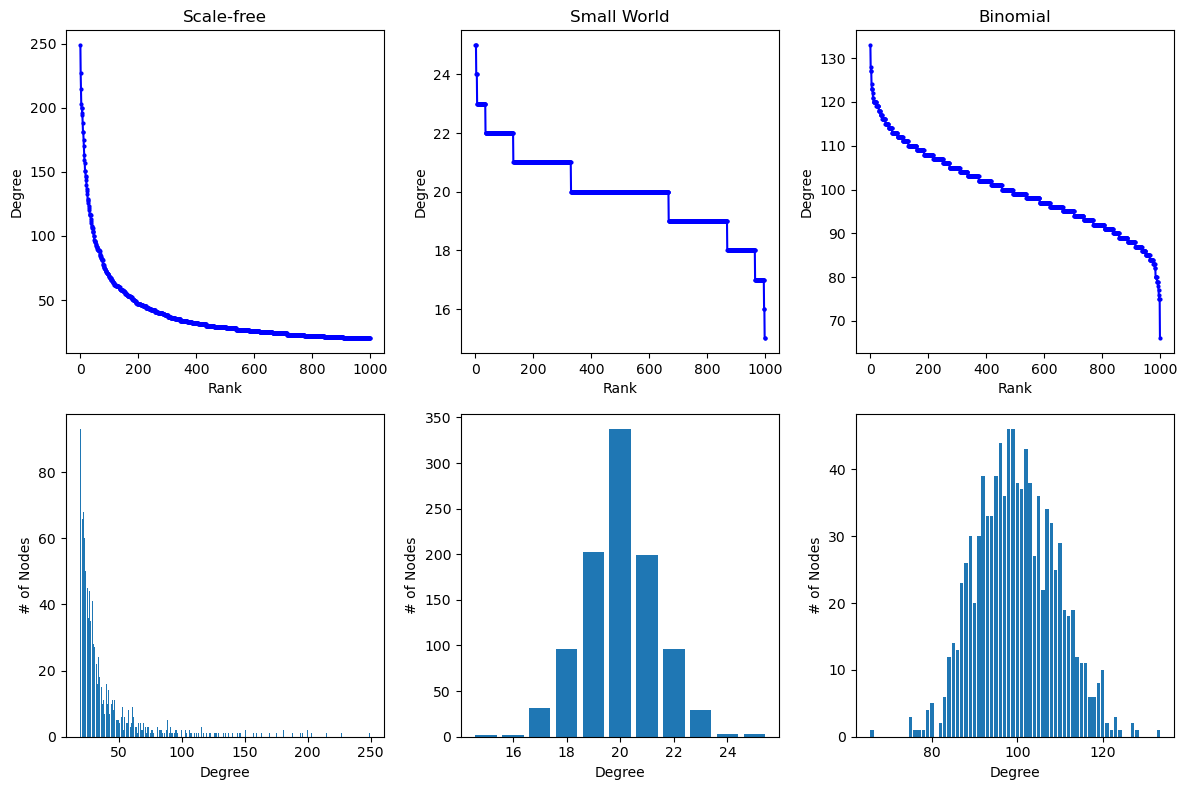

In [99]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

# Plotting on the first subplot (top-left)
ax1 = axes[0, 0]
ax1.plot(x1, "b-", marker="o", markersize=2)
ax1.set_title("Scale-free")
ax1.set_ylabel("Degree")
ax1.set_xlabel("Rank")

# Plotting on the second subplot (top-center)
ax2 = axes[0, 1]
ax2.plot(x2, "b-", marker="o", markersize=2)
ax2.set_title("Small World")
ax2.set_ylabel("Degree")
ax2.set_xlabel("Rank")

# Plotting on the third subplot (top-right)
ax3 = axes[0, 2]
ax3.plot(x3, "b-", marker="o", markersize=2)
ax3.set_title("Binomial")
ax3.set_ylabel("Degree")
ax3.set_xlabel("Rank")

# Plotting on the fourth subplot (bottom-left)
ax4 = axes[1, 0]
ax4.bar(*np.unique(x1, return_counts=True))
ax4.set_xlabel("Degree")
ax4.set_ylabel("# of Nodes")

# Plotting on the fifth subplot (bottom-center)
ax5 = axes[1, 1]
ax5.bar(*np.unique(x2, return_counts=True))
ax5.set_xlabel("Degree")
ax5.set_ylabel("# of Nodes")

# Plotting on the sixth subplot (bottom-right)
ax6 = axes[1, 2]
ax6.bar(*np.unique(x3, return_counts=True))
ax6.set_xlabel("Degree")
ax6.set_ylabel("# of Nodes")

# Adjust layout for better spacing
fig.tight_layout()

# Show the plots
plt.show()

In [102]:
# fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

# # Plotting on the first subplot (top-left)
# ax1 = axes[0, 0]
# ax1.plot(x1, "b-", marker="o")
# ax1.set_title("Degree Rank Plot")
# ax1.set_ylabel("Degree")
# ax1.set_xlabel("Rank")

# # Plotting on the second subplot (top-center)
# ax2 = axes[0, 1]
# ax2.plot(x2, "b-", marker="o")
# ax2.set_title("Degree Rank Plot (Same Data)")
# ax2.set_ylabel("Degree")
# ax2.set_xlabel("Rank")

# # Plotting on the third subplot (top-right)
# ax3 = axes[0, 2]
# ax3.plot(x3, "b-", marker="o")
# ax3.set_title("Degree Rank Plot (Same Data)")
# ax3.set_ylabel("Degree")
# ax3.set_xlabel("Rank")


# # Plotting on the fourth subplot (bottom-left)
# ax4 = axes[1, 0]
# ax4.bar(*np.unique(x1, return_counts=True))
# ax4.set_title("Degree histogram")
# ax4.set_xlabel("Degree")
# ax4.set_ylabel("# of Nodes")

# # Plotting on the fifth subplot (bottom-center)
# ax5 = axes[1, 1]
# ax5.bar(*np.unique(x2, return_counts=True))
# ax5.set_title("Degree histogram (Same Data)")
# ax5.set_xlabel("Degree")
# ax5.set_ylabel("# of Nodes")

# # Plotting on the sixth subplot (bottom-right)
# ax5 = axes[1, 2]
# ax5.bar(*np.unique(x3, return_counts=True))
# ax5.set_title("Degree histogram (Same Data)")
# ax5.set_xlabel("Degree")
# ax5.set_ylabel("# of Nodes")

# # Adjust layout for better spacing
# fig.tight_layout()

# # Show the plots
# plt.show()

## Simulating SIR spread through networks

Steps:
Result: For same network size and seed we want multiple iterations of SIR, Ultimately 3 different averaged results (one per network type)
We want average behabiour of the same network type given same seed and N. We want to vary reproductive number or something like this. Ideally 3x3 plot.

Steps-
1.Choose a network size
2.Choose parameter to vary
3.Compute average behavior for each network

Optional:
v


In [115]:
def trends_extractor(trends):
    '''Retrieves SIR populations from model trends'''
    SIR = trends[0]['trends']['node_count']
    deltas = trends[0]['trends']['status_delta']
    S, I, R = SIR[0], SIR[1], SIR[2]
    dS, dI, dR = deltas[0], deltas[1], deltas[2]
    return [S, I, R, dS, dI, dR]


def multiple_run_SIR(graph, beta, gamma, perc_infected= None,infected_nodes=None, nruns= 200):
    '''Runs model many times on sam stat'''
    S_lst = []
    I_lst= []
    R_lst = [] 
    dS_lst = []
    dI_lst= []
    dR_lst = [] 
    for repetitions in range(50):
        model, iterations = simple_sir(graph, beta, gamma, perc_infected= perc_infected, infected_nodes=infected_nodes,iterations = nruns)
        trends = model.build_trends(iterations)
        S, I, R, dS, dI, dR = trends_extractor(trends)
        S_lst.append(S)
        I_lst.append(I)
        R_lst.append(R)
        dS_lst.append(dS)
        dI_lst.append(dI)
        dR_lst.append(dR)
    S_avg = np.mean(np.array(S_lst), axis=0)
    I_avg = np.mean(np.array(I_lst), axis=0)
    R_avg = np.mean(np.array(R_lst), axis=0)
    dS_avg = np.mean(np.array(dS_lst), axis=0)
    dI_avg = np.mean(np.array(dI_lst), axis=0)
    dR_avg = np.mean(np.array(dR_lst), axis=0)
    return [S_avg, I_avg, R_avg, dS_avg, dI_avg, dR_avg]

        
    
    

#### Running multirun of SIR spread through different network types

In [116]:
beta = 0.001
gamma =0.01
percentage_infected = 0.01
nruns = 300



infected = [1 ,50, 99]
# Ns = [100]
# scale_g = scale_free(Ns)
# small_g = smallworld(Ns)
# binom_g = binomial(Ns)

# Running 
S1, I1 , R1, dS1, dI1, dR1 = multiple_run_SIR(scale_g[-1], beta, gamma, perc_infected= None, infected_nodes=infected, nruns=300)
S2, I2 , R2, dS2, dI2, dR2 = multiple_run_SIR(small_g[-1], beta, gamma, perc_infected= None, infected_nodes=infected, nruns= 300)
S3, I3 , R3, dS3, dI3, dR3 = multiple_run_SIR(binom_g[-1], beta, gamma, perc_infected= None, infected_nodes=infected, nruns= 300)


# plt.plot()

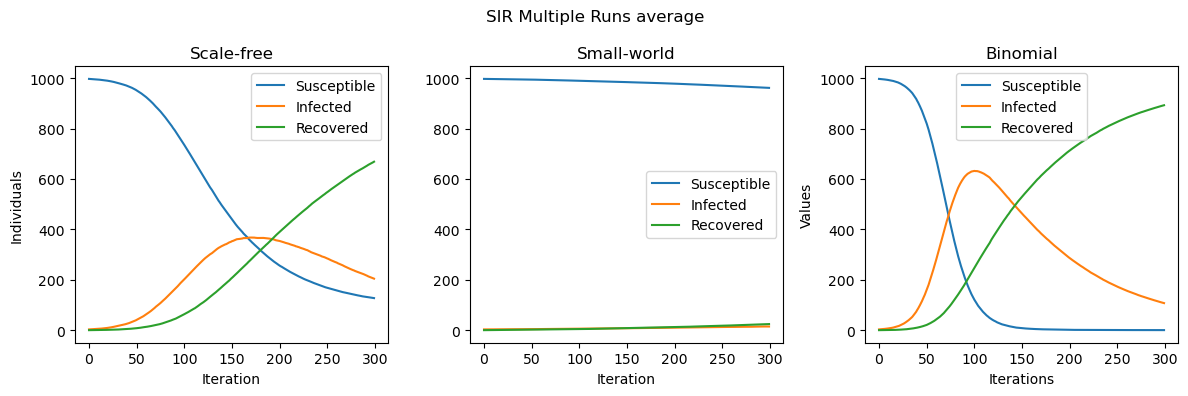

In [122]:
# Creating subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True,figsize=(12, 4))


# Plotting three lines in each subplot with different labels
ax1.plot(S1, label='Susceptible')
ax1.plot(I1, label='Infected')
ax1.plot(R1, label='Recovered')
ax1.set_title('Scale-free')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Individuals')
ax1.legend()

ax2.plot(S2, label='Susceptible')
ax2.plot(I2, label='Infected')
ax2.plot(R2, label='Recovered')
ax2.set_title('Small-world')
ax2.set_xlabel('Iteration')
ax2.legend()

ax3.plot(S3, label='Susceptible')
ax3.plot(I3, label='Infected')
ax3.plot(R3, label='Recovered')
ax3.set_title('Binomial')
ax3.set_xlabel('Iteration')
ax3.legend()


# Adding overall titles and labels
fig.suptitle('SIR Multiple Runs average')
plt.xlabel('Iterations')
plt.ylabel('Values')

# Adjusting layout
plt.tight_layout()

# Show the plot
plt.show()

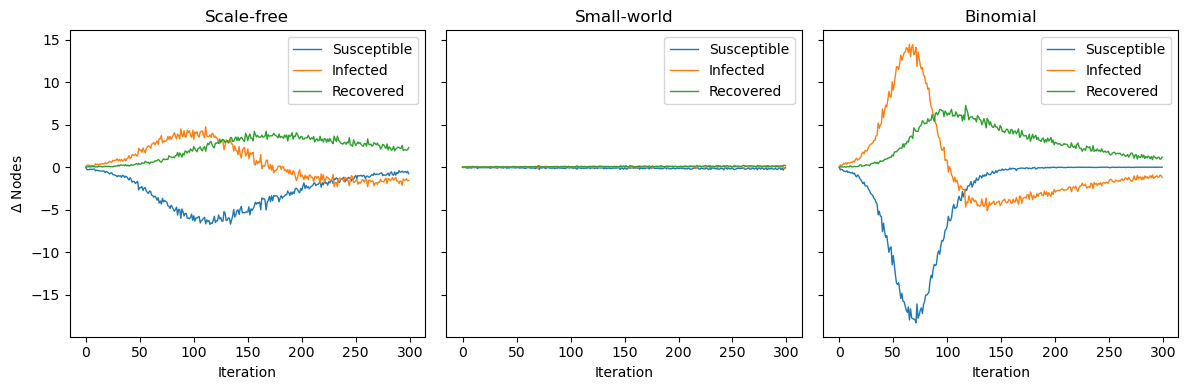

In [124]:
# Creating subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12, 4))


# Plotting three lines in each subplot with different labels
ax1.plot(dS1, label='Susceptible', alpha=1, linewidth=1)
ax1.plot(dI1, label='Infected',  alpha=1, linewidth=1)
ax1.plot(dR1, label='Recovered',  alpha=1, linewidth=1)
ax1.set_title('Scale-free')
ax1.set_xlabel('Iteration')
ax1.set_ylabel(r'$\Delta$ Nodes')
ax1.legend()

ax2.plot(dS2, label='Susceptible',linewidth=1)
ax2.plot(dI2, label='Infected',linewidth=1)
ax2.plot(dR2, label='Recovered',linewidth=1)
ax2.set_title('Small-world')
ax2.set_xlabel('Iteration')
ax2.legend()

ax3.plot(dS3, label='Susceptible',linewidth=1)
ax3.plot(dI3, label='Infected',linewidth=1)
ax3.plot(dR3, label='Recovered',linewidth=1)
ax3.set_title('Binomial')
ax3.set_xlabel('Iteration')
ax3.legend()


# Adding overall titles and labels
# fig.suptitle('Lines over Iterations')
# plt.xlabel('Iterations')
# plt.ylabel('Values')

# Adjusting layout
plt.tight_layout()
# Adjusting the linewidth for all lines in the figure
fig.set_linewidth(5)

# Show the plot
plt.show()

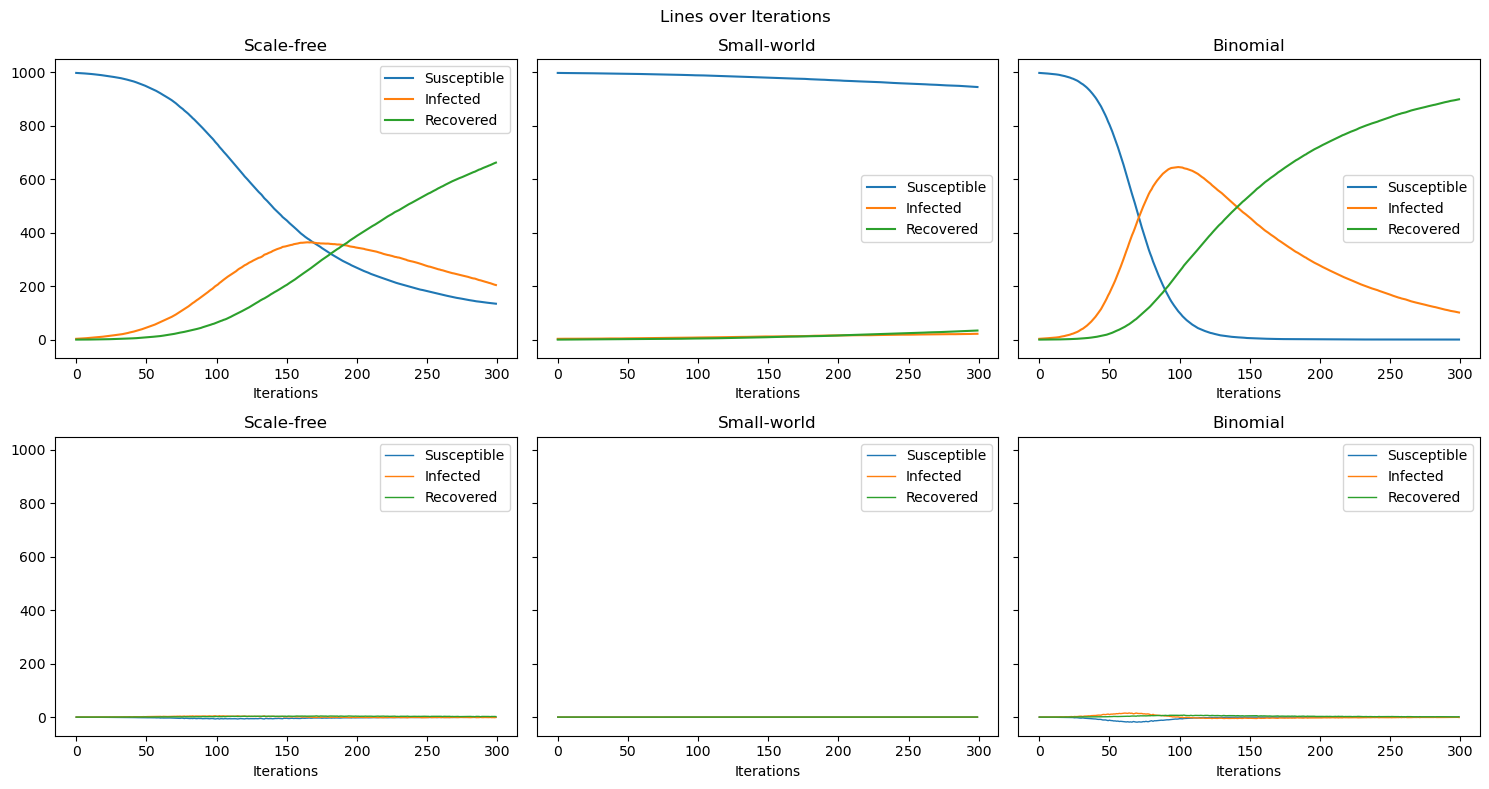

## Real data: Applying dynamic Vaccination strategy 

In [ ]:
### Steps:
# 1.Load graph data
# 2.Instantiate sIR model into graph
# 3.


In [39]:
import pandas as pd
import csv
import pygraphviz

Reading Edge list data and creating network

In [40]:
csv_file = "transmission_network.csv"

# Read the CSV file into a list of dictionaries using DictReader

csv_reader = csv.reader(open("transmission_network.csv", 'r'))

def edge_extractor(csv_reader):
    edge_list= []
    for k, line in enumerate(csv_reader):
        if k == 0:
            fieldnames = line[0].split(";")[1:]
        if k > 0:
            connections = line[0].split(";")[1:]
            a = fieldnames[k-1]
            for indx, weight in enumerate(connections):
                if weight != '0':
                    b = fieldnames[indx]
                    text = a + ' ' + b 
                    edge_list.append(text)
    return edge_list

edges = edge_extractor(csv_reader)

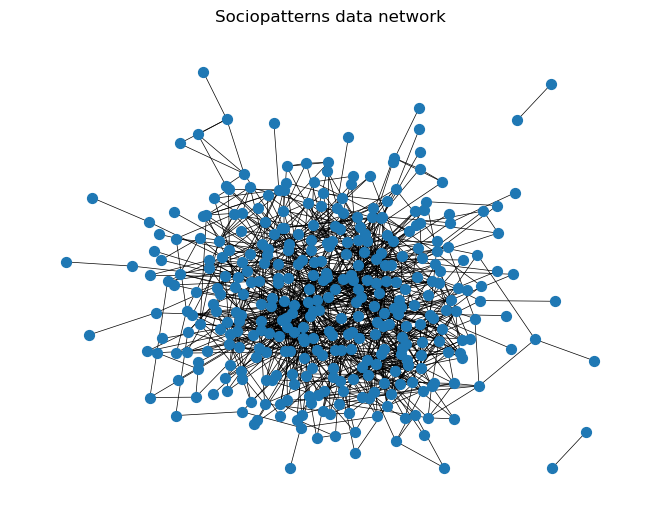

In [44]:
G = nx.parse_edgelist(edges, nodetype=int)
pos = nx.nx_agraph.graphviz_layout(G)
nx.draw(G, pos, node_size=50, width=0.5)

# Display the graph
plt.title('title')
plt.show()

In [ ]:
def simple_sir(graph, beta, gamma, perc_infected,infected_nodes=None,iterations = 200):
    model = ep.SIRModel(graph)  
    cfg = mc.Configuration()
    cfg.add_model_parameter('beta', beta) # infection rate
    cfg.add_model_parameter('gamma', gamma) # recovery rate
    
    if not infected_nodes:
#         print("using percentage")
        cfg.add_model_parameter("percentage_infected", perc_infected)
        model.set_initial_status(cfg)
    else:
#         print('using infected nodes')
        cfg.add_model_initial_configuration("Infected", infected_nodes)
        model.set_initial_status(cfg)

    iterations = model.iteration_bunch(iterations, node_status=True)
    return model, iterations

In [ ]:
def multi_run_vaccine(graph):
    for run in total_iterations in range(5)
    
def simple_sir2(graph, infected):
    beta = 0.001
    gamma = 0.01
    model = ep.SIRModel(graph)  
    cfg = mc.Configuration()
    cfg.add_model_parameter('beta', beta) # infection rate
    cfg.add_model_parameter('gamma', gamma) # recovery rate
    cfg.add_model_initial_configuration("Infected", infected_nodes)
    model.set_initial_status(cfg)
    iteration = iteration()
    return iteration
    
def random_vaccination(graph, infected_nodes):
    random_infected  = [random.randint(1, 365) for r in range(5)]
    model, iteration = simple_sir(graph, infected)
    

In [142]:
def random_model(budget,t_acc):
    
    model_vramd = ep.SIRModel(g_v) #create Model

    # Model configuration
    config = mc.Configuration()
    config.add_model_parameter('beta', beta)
    config.add_model_parameter('gamma', gamma)
    config.add_model_parameter("fraction_infected", infected)
    model_vramd.set_initial_status(config)

    #Model
    iterations = model_vramd.iteration_bunch(0) #Start with empty array of iteration
    n_tests = 0  #Start with 0 tests
    nodes = list(nx.nodes(g_v))


    for i in range(200): #Do iteration one by one
        model_vramd, n_tests, nodes = vaccinations_random(model_vramd,g_v,budget, t_acc, n_tests,nodes)
        iterations += model_vramd.iteration_bunch(1)
    trends = model_vramd.build_trends(iterations)
    viz = DiffusionTrend(model_vramd, trends)
    
    return viz

358
1265


In [ ]:
def random_model(vaccine_budget, graph, test_budget, t_accu, n_iterations= 300):
    beta = 0.001
    gamma = 0.01
    total_tests = 200
    model = ep.SIRModel(graph) #create Model

    # Model configuration
    config = mc.Configuration()
    config.add_model_parameter('beta', beta)
    config.add_model_parameter('gamma', gamma)
    config.add_model_parameter("fraction_infected", infected)
    model.set_initial_status(config)

    #Model
    iterations = model.iteration_bunch(0) #Start with empty array of iteration
    n_tests = 0  #Start with 0 tests
    nodes = list(nx.nodes(graph))
    test_iterations = total_tests//test_budged
    tests = [test_budget for k in range(test_iterations)]
    
    vacc_iterations = total_tests//test_budged
    vaccines = [test_budget for k in range(test_iterations)]
    
    for k in range(n_iterations): #Do iteration one by one
        if len(tests) > 0:
            n_tests = tests.pop()
            model, nodes = random_vaccination(model,nodes,graph,vaccines,accuracy,n_tests= 200, nodes)
            iterations += model.iteration_bunch(1)
        else:
            iterations += model.iteration_bunch(1)
            
    trends = model_vramd.build_trends(iterations)
    viz = DiffusionTrend(model_vramd, trends)
    
    return viz


def random_vaccination(model,nodes,graph,vaccines,accuracy,n_tests= 200, nodes):
    "Implements vaccination ot random nodes and testing random node to the mas number of people"
    finished= False
    test_nodes = nodes
    while n_tests > 0 and vaccines> 0:
        test_node = np.random.choice(nodes_c)
        if model.status[test_node] == 0:
            model.status[test] = 2 #Vaccination of the node 
            test_nodes.remove(test)
            vaccines -= 1
        n_tests -= 1
    return model, nodes
